In [30]:
# import packages
import requests
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib
from tastypie import http
import http.client
from pandas import Series, DataFrame
import time
import matplotlib.pyplot as plt


# Scraping the data

In [ ]:
# Code to extract key features from the listings on cars.com

'''
Defining a dictionary that will store the relevant details from each listing,
such as vehicle id, price, dealer ratings, car color etc.

'''
listing_dict={'vehicle_id':[],'listing_name':[],'vehicle_brand':[],
              'price':[],'dealer_name':[],'dealer_state':[],
              'dealer_rating':[],'dealer_num_review':[],'car_color':[],'dealer_url':[]}
'''
Defining a for loop to iterate over the first 50 pages of available listings
'''

for i in range(1,51):
    '''
    The general URL format only includes changing the page number.
    The filtering criteria used is nearest car listings for zip 
    code 29201.
    
    The try-except combination below ensures that the server transfer
    continues if the expected file size limit is breached. This is also 
    known as handling 'IncompleteRead' exceptions
    
    '''
    header = {'User-Agent': 'Mozilla/6.0'}
    URL=("https://www.cars.com/for-sale/searchresults.action/?dealerType=localOnly&page="+str(i)+
         "&perPage=100&rd=99999&searchSource=GN_BREADCRUMB&sort=distance-nearest&zc=29201")
    try:
        oururl= urllib.request.urlopen(URL).read()
    except (http.client.IncompleteRead) as e:
        page = e.partial
    soup = BeautifulSoup(oururl)
    
    '''
    Details of each listing are stored in a json format. temp_list extracts these details 
    for each page. 
    
    Details of each listing are located in seperate json type structures. The length of
    the temp_list file, threfore provides the number of listings on each page
    '''
    
    temp_list=json.loads(soup.find("script", {"type":"application/ld+json","id":""}).text)
    length=len(temp_list)
    
    '''
    We then iterate over all the listings on a given page and store the relevant 
    listing details in the dictionary created outside of the loop
    
    For some features such as dealer rating and number of review, 
    I had to add error handling because some of the dealers do not have ratings
    available and this causes the code to stop
    '''
    
    for j in range(0,len(temp_list)):
        listing_dict['vehicle_id'].append(temp_list[j]['vehicleIdentificationNumber'])
        listing_dict['listing_name'].append(temp_list[j]['name'])
        listing_dict['vehicle_brand'].append(temp_list[j]['brand']['name'])
        listing_dict['price'].append(temp_list[j]['offers']['price'])
        listing_dict['dealer_name'].append(temp_list[j]['offers']['seller']['name'])
        listing_dict['dealer_state'].append(temp_list[j]['offers']['seller']['address']['addressRegion'])
        try:
            listing_dict['dealer_rating'].append(temp_list[j]['offers']['seller']['aggregateRating']['ratingValue'])
        except KeyError:
            listing_dict['dealer_rating'].append("")
        try:
            listing_dict['dealer_num_review'].append(temp_list[j]['offers']['seller']['aggregateRating']['reviewCount'])
        except KeyError:
            listing_dict['dealer_num_review'].append("")
        listing_dict['car_color'].append(temp_list[j]['color'])
        listing_dict['dealer_url'].append(temp_list[j]['url'])
        
    print('Page:',i)

    


In [ ]:
# I convert the dictionary into a dataframe, with columns as the dictionary
# key, and the values as the dictionary value
listings_df=pd.DataFrame(dict([ (k,Series(v)) for k,v in listing_dict.items() ]))

In [ ]:
listings_df.to_excel('Listings_Python_1Nov.xlsx')

In [ ]:
# Code to Extract detailed features from each listing
length=listings_df.shape[0]+1
detailed_features2dot5k_3k=[]
for i in range(2501,3001):
    URL=listings_df['dealer_url'][i]
    header = {'User-Agent': 'Mozilla/6.0'}
    try:
        oururl= urllib.request.urlopen(URL).read()
    except (http.client.IncompleteRead) as e:
        page = e.partial
    soup=BeautifulSoup(oururl,'lxml')
    #temp=soup.find("ul",{"class":"vdp-details-basics__features-list"}).text.split("\n")
    try:
        detailed_features2dot5k_3k.append(soup.find("ul",{"class":"vdp-details-basics__features-list"}).text.split("\n"))
    except:
        detailed_features2dot5k_3k.append("")
    #if i in np.linspace(100,5000,50):
    #    time.sleep(10)
    else:
        print("Listing number"+str(i))

    

In [ ]:
# Convert detailed features to dataframe:
#df1=pd.DataFrame({0:detailed_features1k})
#df2=pd.DataFrame({0:detailed_features2k})
#df3=pd.DataFrame({0:detailed_features2k_2dot5k})
df4=pd.DataFrame({0:detailed_features2dot5k_3k})

#df1.to_excel('Detailed_features_first966.xlsx')
#df2.to_excel('Detailed_features_1001_1503.xlsx')
#df3.to_excel('Detailed_features_2001_2500.xlsx')
df4.to_excel('Detailed_features_2501_3000.xlsx')


In [ ]:
df1.tail()

In [ ]:
# Extracting detailed features from each of the listings (~5000)
# The above code also provides me with dealer_url for ~5000 listings
# In the subsequent code, I access these dealer urls to extract
# detailed car features

# I need to iterate over the entire length of the listings_df
# Hence, I extract the length of the same
length1=listings_df.shape[0]+1

'''
Create an empty list to store list of features under each feature category
'''
listing_features=[]

for i in range(length1):
    '''
    Extract the URL from each listing to feed into Beautifulsoup
    '''
    
    URL =listings_df['dealer_url'][i]
    header = {'User-Agent': 'Mozilla/6.0'}
    try:
        oururl= urllib.request.urlopen(URL).read()
    except (http.client.IncompleteRead) as e:
        page = e.partial
    soup = BeautifulSoup(oururl)
    
    '''
    The data structure for the detailed listing is slightly complicated.
    There are 3-6 categories for detailed feature:
    1. Safety
    2. Entertainment
    3. Safety
    4. Exterior
    5. Seating
    
    I therefore store the result from each listing as a dictionary, with
    the key being one of the broad feature categories as above, and the 
    values being each feature within the category
    
    Therefore, I initialize a result dictionary at the beginning of each iteration 
    of the loop, to store the contents from features
    
    The detailed features for each listing are nested within a parent class called:
    details-features-list--normalized-features, which is extracted from the URL
    
    -->It contains several children classes, called "cui-heading-2", which store
    the five broad feature categories defined above. This becomes the 'Key'
    
    --> Each childrent class also has its own childrent class, called 
    "details-feature-list__item", which is the actual feature. These become
    the 'value'. Since there are multiple values within each 'Key', we iterate over
    all of them
    
    '''
    
    result = {}
    for group in soup.find_all("div", {"class": "details-feature-list--normalized-features"}):
        result[group.find("h2", {"class": "cui-heading-2"}).text] = [itm.text for itm in group.find_all("li", {"class": "details-feature-list__item"})]
    listing_features.append(result)






In [ ]:
listing_features[4898]

In [ ]:
# listing_features_1000
# listing_features_2k3k
# listing_features_2k3k1
# listing_features_3k4k
# listing_features_4k5k

In [ ]:
# We create a dataframe of all the features. The categories become the 
# columns, while the values remains values for each observation
df_features=pd.DataFrame(listing_features)

In [ ]:
df_features.to_excel('Features_Python1.xlsx')
    

In [9]:
Listings_Python=pd.read_excel('Listings_Python1.xlsx')
Features_Python=pd.read_excel('Features_Python1.xlsx')

# Exploring the data

In [295]:
# Combine the listings with their features:
df=pd.concat([Listings_Python, Features_Python],axis=1).replace(np.nan, '', regex=True)

In [320]:
# Aggregating price by brand
df_brand=df.groupby(['vehicle_brand']).agg({'price':'mean'}).reset_index().sort_values('price')

Text(0.5, 1.0, 'Average Price by Brand')

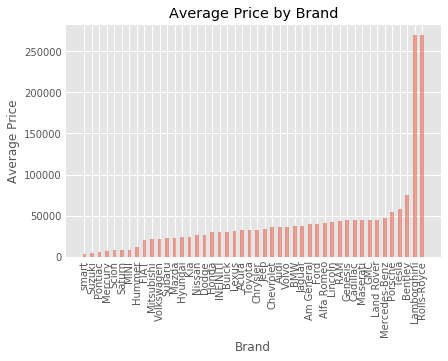

In [321]:
# Plotting brand vs average price
plt.style.use('ggplot')
fig, ax = plt.subplots() # make figure and axes separate objects
plt.bar(df_brand['vehicle_brand'], df_brand['price'], align='center',alpha=.5, width=0.5)
plt.xticks(df_brand['vehicle_brand'])
# Rotating x-axis labels to make them visible
plt.xticks(rotation=90)
plt.ylabel('Average Price')
plt.xlabel('Brand')
plt.title('Average Price by Brand')
#fig.savefig('Launch.jpg', transparent=False, dpi=80, bbox_inches="tight")

Text(0.5, 1.0, 'Average Price by Brand')

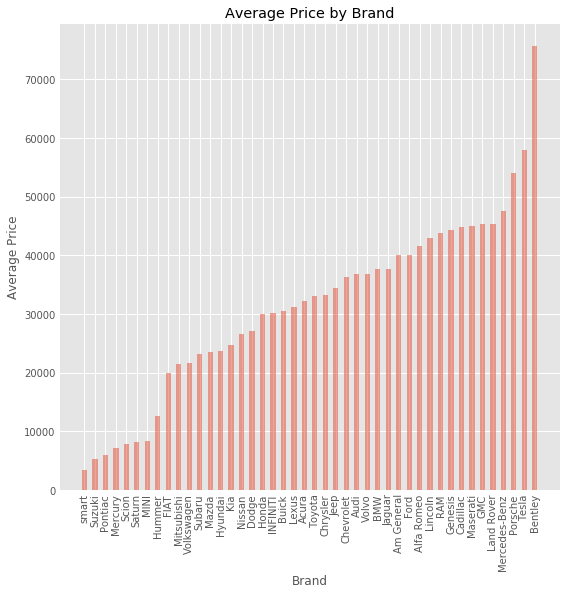

In [322]:
# It seems like Lamborghini and Rolls Royce are the obvious outliers.
# I leave those two out and redo the plot

df_brand1=df_brand[~df_brand.vehicle_brand.isin(['Lamborghini','Rolls-Royce'])]

plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.bar(df_brand1['vehicle_brand'], df_brand1['price'], align='center',alpha=.5, width=0.5)
plt.xticks(df_brand1['vehicle_brand'])
# Rotating x-axis labels to make them visible
plt.xticks(rotation=90)
plt.ylabel('Average Price')
plt.xlabel('Brand')
plt.title('Average Price by Brand')




In [298]:
# This is kind of expected, with luxury brands such as Bentley, Tesla, MB etc.,
# having the highest prices

# But I aim to understand the prices vs. features relationship
# Are the prices for used cars higher for more exterior or for more convenience 
# fetures, and so on....

# I add the number of features for Safety, Entertainment, Convenience, Exterior & Seating
# Each of the elements in this column is a list of features and I extract their number
#df.replace('',0)
num_convenience=[]
num_entertainment=[]
num_safety=[]
num_exterior=[]
num_seating=[]
for i in range (df.shape[0]):
    
    if len(df['Convenience'][i])==0:
        num_convenience.append(0)
    else:
        num_convenience.append(len(df['Convenience'][i].split(",")))
        
    if len(df['Safety'][i])==0:
        num_safety.append(0)
    else:
        num_safety.append(len(df['Safety'][i].split(",")))

    if len(df['Exterior'][i])==0:
        num_exterior.append(0)
    else:
        num_exterior.append(len(df['Exterior'][i].split(",")))

    if len(df['Seating'][i])==0:
        num_seating.append(0)
    else:
        num_seating.append(len(df['Seating'][i].split(",")))

    if len(df['Entertainment'][i])==0:
        num_entertainment.append(0)
    else:
        num_entertainment.append(len(df['Entertainment'][i].split(",")))



In [299]:
df['num_safety']=num_safety
df['num_entertainment']=num_entertainment
df['num_exterior']=num_exterior
df['num_seating']=num_seating
df['num_convenience']=num_convenience

In [314]:
df.describe()

,Unnamed: 0,price,dealer_num_review,Unnamed: 0,num_safety,num_entertainment,num_exterior,num_seating,num_convenience
count,4900.00000,4756.000000,4627.000000,4900.00000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000
mean,2449.50000,36656.006728,436.925654,2449.50000,3.512449,1.687551,1.387959,1.451633,2.588980
std,1414.65249,17004.374721,772.240307,1414.65249,1.445354,0.811813,0.826373,1.483772,1.508106
min,0.00000,1950.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1224.75000,25800.000000,47.000000,1224.75000,3.000000,1.000000,1.000000,0.000000,1.000000
50%,2449.50000,37012.000000,163.000000,2449.50000,3.000000,2.000000,1.000000,1.000000,3.000000
75%,3674.25000,45675.500000,515.000000,3674.25000,4.000000,2.000000,2.000000,3.000000,4.000000
max,4899.00000,324990.000000,12096.000000,4899.00000,7.000000,4.000000,4.000000,5.000000,7.000000


In [326]:
'''
The maximum number of 
conveience features=7
Safety features=7
Entertainment features=4
Exterior features=4
'''

# I look at the average price by convenience features:
df_convenience=df.groupby(['num_convenience']).agg({'price':'mean'}).reset_index()
df_safety=df.groupby(['num_safety']).agg({'price':'mean'}).reset_index()
df_entertainment=df.groupby(['num_entertainment']).agg({'price':'mean'}).reset_index()
df_exterior=df.groupby(['num_exterior']).agg({'price':'mean'}).reset_index()
df_seating=df.groupby(['num_seating']).agg({'price':'mean'}).reset_index()


[Text(0, 0.5, 'Avg. Price'),
 Text(0.5, 0, '# of Features'),
 Text(0.5, 1.0, 'Avg. Price vs # of Features')]

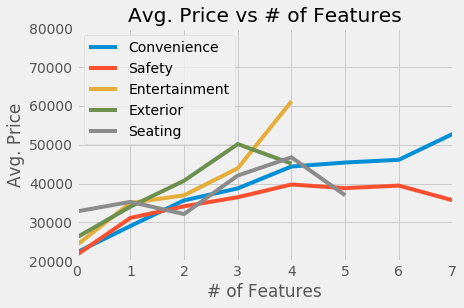

In [345]:
# Plotting average price versus number of features
df['price']=pd.to_numeric(df['price'])
df['num_convenience']=pd.to_numeric(df['num_convenience'])

# Setting up plot styles
plt.style.use('fivethirtyeight') # select a style (theme) for plot
fig, ax = plt.subplots() # make figure and axes separate objects
ax.set_xlim([0, 7]) # set axis range
ax.set_ylim([20000, 80000]) # set axis range


# Using line plots with num of features on x and price on y
plt.plot(df_convenience['num_convenience'], df_convenience['price'], label='Convenience')
plt.plot(df_safety['num_safety'], df_safety['price'], label='Safety')
plt.plot(df_entertainment['num_entertainment'], df_entertainment['price'],label='Entertainment' )
plt.plot(df_exterior['num_exterior'], df_exterior['price'], label='Exterior')
plt.plot(df_seating['num_seating'], df_seating['price'], label='Seating')

# Adding finishing touches to the plot
plt.legend()
ax.set(title='Avg. Price vs # of Features', xlabel='# of Features',
       ylabel="Avg. Price") # plot title, axis labels



In [407]:
# Price by manufacturing years and brand:
df['year']=df['listing_name'].str[:4]
df['year']=pd.to_numeric(df['year'])
df['dealer_rating']=pd.to_numeric(df['dealer_rating'])

In [425]:
### Next I test these effects econometrically
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm
from stargazer.stargazer import Stargazer


# Define the model
Price_OLS = smf.ols(formula='price ~ dealer_rating + dealer_num_review +  C(year) + C(vehicle_brand) \
                           + num_convenience + num_safety + num_exterior + num_seating + num_entertainment', data=df)
# Estimate the model
res = Price_OLS.fit(cov_type='HC1')
# Show the results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 2.485e+04
Date:                Sat, 02 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:30:33   Log-Likelihood:                -47754.
No. Observations:                4493   AIC:                         9.567e+04
Df Residuals:                    4414   BIC:                         9.617e+04
Df Model:                          78                                         
Covariance Type:                  HC1                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

C:\Users\Devashish\Anaconda3_1\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 80, but rank is 70
  'rank is %d' % (J, J_), ValueWarning)
